## Goal: To classify the observations with no MoA annotation

In [16]:
# import libraries

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.manifold import TSNE

from sklearn.metrics import classification_report, confusion_matrix

import model

### 1. Load and inspect the features and targets of the dense core

In [2]:
# Load the features and targets

X_train_core = pd.read_csv('X_train_core.csv', index_col=0)
X_validate_core = pd.read_csv('X_validate_core.csv', index_col=0)
X_test_core = pd.read_csv('X_test_core.csv', index_col=0)

Y_train_core = pd.read_csv('Y_train_core.csv', index_col=0)
Y_validate_core = pd.read_csv('Y_validate_core.csv', index_col=0)
Y_test_core = pd.read_csv('Y_test_core.csv', index_col=0)

# Print their shapes
X_train_core.shape, X_validate_core.shape, X_test_core.shape, \
Y_train_core.shape, Y_validate_core.shape, Y_test_core.shape

((13558, 50), (3410, 50), (1892, 50), (13558, 206), (3410, 206), (1892, 206))

In [3]:
# Make sure the index match between X and Y

print((X_train_core.index == Y_train_core.index).sum())
print((X_validate_core.index == Y_validate_core.index).sum())
print((X_test_core.index == Y_test_core.index).sum())

13558
3410
1892


In [4]:
# Take a peek at train features
X_train_core.head(2)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
sig_id,,,,,,,,,,,,,,,,,,,,,
id_887911684,-0.113079,-0.126488,-0.045746,-0.065418,0.009277,0.058472,-0.015255,0.286149,-0.071498,0.029081,...,-0.004725,-0.046098,-0.000499,0.032700,-0.090504,0.031419,-0.122123,0.024048,-0.122287,-0.012305
id_294d38ce4,-0.239770,-0.242513,0.469707,0.132345,-0.079247,0.053615,-0.062062,0.159616,-0.169681,0.026081,...,-0.023376,0.004647,0.002614,0.044699,0.061037,-0.002453,-0.014456,-0.020474,0.008282,0.037586


In [5]:
# Take a peek at validate features
Y_train_core.head(2)

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,
id_887911684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_294d38ce4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


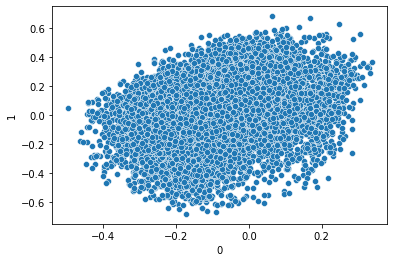

In [6]:
# Quick viz to confirm the correct separation

sns.scatterplot(data=X_train_core, x='0', y='1')
plt.show()

**Takeaways**: The cluster 'dense core' are successfully substracted from train/validate/test.

### 2. Explore the target variable

In [7]:
# Compute the counts of MoA annotations for the sig_id and 
# store the number in a new column

Y_train_core['label_counts'] = Y_train_core.sum(axis=1)
Y_validate_core['label_counts'] = Y_validate_core.sum(axis=1)
Y_test_core['label_counts'] = Y_test_core.sum(axis=1)

# Take a peek at the Y_train_core
Y_train_core.head()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,label_counts
sig_id,,,,,,,,,,,,,,,,,,,,,
id_887911684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_294d38ce4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_b12cf3d9c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id_d8f5ca938,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,2
id_c4eaa645d,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
# Compute the percentage of sig_ids with no MoA annotation in train

pd.concat([Y_train_core.label_counts.value_counts(),
           Y_train_core.label_counts.value_counts(normalize=True)], axis=1).sort_index()

,label_counts,label_counts
0,4974,0.366868
1,7815,0.576412
2,532,0.039239
3,204,0.015046
4,29,0.002139
5,4,0.000295


In [9]:
# Compute the percentage of sig_ids with no MoA annotation in validate

pd.concat([Y_validate_core.label_counts.value_counts(),
           Y_validate_core.label_counts.value_counts(normalize=True)], axis=1).sort_index()

,label_counts,label_counts
0,1228,0.360117
1,2009,0.589150
2,114,0.033431
3,45,0.013196
4,11,0.003226
5,3,0.000880


In [10]:
# Compute the percentage of sig_ids with no MoA annotation in validate

pd.concat([Y_test_core.label_counts.value_counts(),
           Y_test_core.label_counts.value_counts(normalize=True)], axis=1).sort_index()

,label_counts,label_counts
0,646,0.341438
1,1146,0.605708
2,55,0.029070
3,37,0.019556
4,8,0.004228


**Takeaways**
- About 35% of the observations has no MoA annotations.
- Picking them out first will greatly reduce the background noise for modeling the observations with MoA labels. 

In [11]:
# Conver the label_counts to a binary categorical variable

Y_train_core['label'] = Y_train_core.label_counts.apply(lambda i: 0 if i == 0 else 1)
Y_validate_core['label'] = Y_validate_core.label_counts.apply(lambda i: 0 if i == 0 else 1)
Y_test_core['label'] = Y_test_core.label_counts.apply(lambda i: 0 if i == 0 else 1)

# Take a peek at a random sample of Y_train_core
Y_train_core.sample(5)

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,label_counts,label
sig_id,,,,,,,,,,,,,,,,,,,,,
id_9240b6e0e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_9a4b7989e,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_4685a4235,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_4f7147c63,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
id_c4b704256,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Create the target variables

y_train = Y_train_core.label
y_validate = Y_validate_core.label
y_test = Y_test_core.label

# Take a look at y_train
y_train.head()

sig_id
id_887911684    0
id_294d38ce4    0
id_b12cf3d9c    1
id_d8f5ca938    1
id_c4eaa645d    1
Name: label, dtype: int64

In [13]:
# Make sure the index match between X and y

print((X_train_core.index == y_train.index).sum())
print((X_validate_core.index == y_validate.index).sum())
print((X_test_core.index == y_test.index).sum())

13558
3410
1892


**Quick Notes**: The new target variable 'label' is successfully created for train/validate/test.

### 3. Visualize the Training dataset

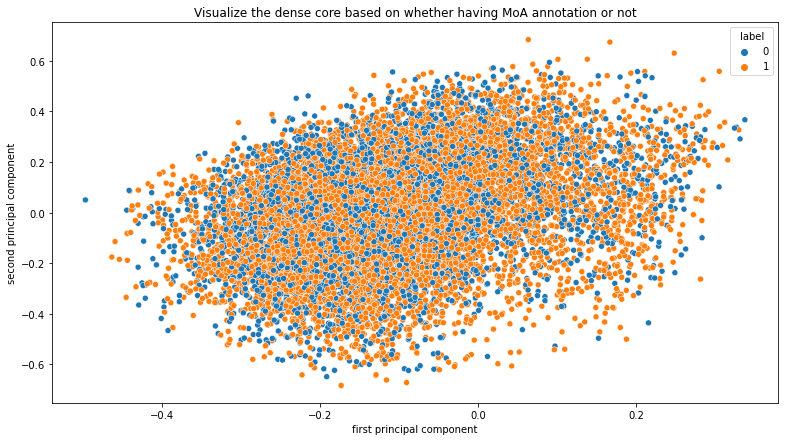

In [14]:
# Combine the features and the target variable in the train dataset
train = pd.concat([X_train_core, y_train], axis=1)

# Visualize the train dataset

plt.figure(figsize=(13,7))
sns.scatterplot(data=train, x='0', y='1', hue='label')
plt.title('Visualize the dense core based on whether having MoA annotation or not')
plt.xlabel('first principal component')
plt.ylabel('second principal component')
plt.show()

In [18]:
# Visualize the train dataset using T-SNE

# Create the tsne object
tsne = TSNE(n_components=3, random_state=123)

# Fit and transform the X_train_core
X_tsne_core = tsne.fit_transform(X_train_core)

# Print the shape
X_tsne_core

array([[ -6.695617  ,  28.89996   ,   0.84724796],
       [ 12.646333  , -24.74342   ,  12.01132   ],
       [  8.000818  ,  24.386814  ,  26.855297  ],
       ...,
       [  8.143256  ,  18.236343  ,  28.382904  ],
       [ -0.4398377 ,  -3.3748982 ,   1.5001471 ],
       [ 13.954537  ,  -4.8487153 , -32.202957  ]], dtype=float32)

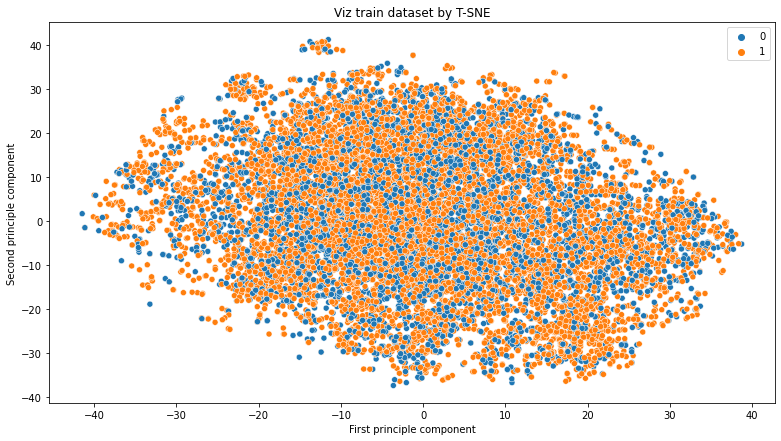

In [22]:
# Convert to dataframe
df_tsne_core = pd.DataFrame(X_tsne_core, index=X_train_core.index)

# Add the target column to the T-SNE transformed features
df_tsne_core['target'] = y_train.values

# Viz the transformed dataset

plt.figure(figsize=(13,7))
sns.scatterplot(data=df_tsne_core, x=df_tsne_core[0], y=df_tsne_core[1], hue='target')

plt.title('Viz train dataset by T-SNE')
plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.legend()
plt.show()

**Takeaways**
- The blue and orange dots are well blended in the 2D scatterplots, even after applying the T-SNE. 

### 3. Modeling - Binary Classification

#### 3-1. Compute baseline accuracy: 63%

In [23]:
baseline = pd.concat([y_train.value_counts(), 
                      y_train.value_counts(normalize=True)], axis=1)
baseline.columns = ['counts', 'percentage']
baseline

,counts,percentage
1,8584,0.633132
0,4974,0.366868


In [24]:
# Print the perfect confusion matrix

perfect_matrix = pd.DataFrame([[4974, 0], [0, 8584]],
                              index=['actural 0', 'actural 1'], 
                              columns=['predicted 0', 'predicted 1'])
perfect_matrix

,predicted 0,predicted 1
actural 0,4974,0
actural 1,0,8584


#### 3-2 Modeling on Train

In [28]:
# Create a list of names of the classifiers

names = [
    'LogisticRegression',
    'Nearest Neighbors(k=5)', 
    'Decision Tree(max_depth=5)',
    'Random Forest(max_depth=5)',
    'AdaBoost, max_depth=3, 100',
    'AdaBoost, max_depth=3, 200',
    'AdaBoost, max_depth=5, 100',
    'AdaBoost, max_depth=5, 50',
    'Gradient Boosting, 0.1, 100',
    'Gradient Boosting, 0.1, 200',
    'Neural Net',
    'Naive Bays',
    'RBF SVM'
]

In [29]:
# Create a list of classifiers to predict the target variable

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(5),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5), 
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100, random_state=123),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=200, random_state=123),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100, random_state=123),
    AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=50, random_state=123),
    GradientBoostingClassifier(learning_rate=.1, n_estimators=100),
    GradientBoostingClassifier(learning_rate=.1, n_estimators=200),
    MLPClassifier(),
    GaussianNB(), 
    SVC(kernel='rbf', gamma = 'auto', probability=True)   
]

In [30]:
# The size between the two should be the same
len(names) == len(classifiers)

True

In [31]:
# Create an empty dataframe

metrics_train = pd.DataFrame()

# Loop through the classifiers

for name, classifier in zip(names, classifiers):
    print(name)
    print('--------------')
    classifier = classifier.fit(X_train_core, y_train)
    y_pred = classifier.predict(X_train_core)
    print(confusion_matrix(y_train, y_pred))
    print(classification_report(y_train, y_pred))
    d = model.estimator_report(name, 'train', y_train, y_pred)
    metrics_train = metrics_train.append(d, ignore_index=True)

LogisticRegression
--------------
[[  54 4920]
 [  50 8534]]
              precision    recall  f1-score   support

           0       0.52      0.01      0.02      4974
           1       0.63      0.99      0.77      8584

    accuracy                           0.63     13558
   macro avg       0.58      0.50      0.40     13558
weighted avg       0.59      0.63      0.50     13558

Nearest Neighbors(k=5)
--------------
[[2518 2456]
 [1301 7283]]
              precision    recall  f1-score   support

           0       0.66      0.51      0.57      4974
           1       0.75      0.85      0.79      8584

    accuracy                           0.72     13558
   macro avg       0.70      0.68      0.68     13558
weighted avg       0.72      0.72      0.71     13558

Decision Tree(max_depth=5)
--------------
[[  51 4923]
 [   8 8576]]
              precision    recall  f1-score   support

           0       0.86      0.01      0.02      4974
           1       0.64      1.00      0.7

In [32]:
# Rank the model by accuracy
metrics_train.sort_values(by='accuracy', ascending=False)

,accuracy,data_type,model_type,precision,recall
6,0.986207,train,"AdaBoost, max_depth=5, 100",0.986219,0.992078
5,0.879702,train,"AdaBoost, max_depth=3, 200",0.883762,0.932665
7,0.876899,train,"AdaBoost, max_depth=5, 50",0.884380,0.926724
4,0.783006,train,"AdaBoost, max_depth=3, 100",0.797198,0.881524
10,0.759920,train,Neural Net,0.764993,0.896086
1,0.722894,train,Nearest Neighbors(k=5),0.747818,0.848439
9,0.682992,train,"Gradient Boosting, 0.1, 200",0.667370,0.995457
8,0.648178,train,"Gradient Boosting, 0.1, 100",0.643018,0.998835
2,0.636303,train,Decision Tree(max_depth=5),0.635306,0.999068
0,0.633427,train,LogisticRegression,0.634309,0.994175


**Takeaways**
- The accuracy of the top six algorithms reached 70%.
- Four of the top six algoes belong to the AdaBoost family. 
- I will use the top six for the validate and test.

#### 3-2 Model the validate and test using the top six algorithms

In [33]:
# Create the AdaBoost object
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=100, random_state=123)

# Fit on train
clf = clf.fit(X_train_core, y_train)

# Predict the y

y_pred_train = clf.predict(X_train_core)
y_pred_validate = clf.predict(X_validate_core)
y_pred_test = clf.predict(X_test_core)

# Print the confustion matrix

print('confusion matrix on train dataset')
print(confusion_matrix(y_train, y_pred_train))
print('confusion matrix on validate dataset')
print(confusion_matrix(y_validate, y_pred_validate))
print('confusion matrix on test dataset')
print(confusion_matrix(y_test, y_pred_test))

# Print the classification report

print('classification report on train dataset')
print(classification_report(y_train, y_pred_train))
print('classification report on validate dataset')
print(classification_report(y_validate, y_pred_validate))
print('classification report on test dataset')
print(classification_report(y_test, y_pred_test))

confusion matrix on train dataset
[[4855  119]
 [  68 8516]]
confusion matrix on validate dataset
[[ 436  792]
 [ 718 1464]]
confusion matrix on test dataset
[[254 392]
 [397 849]]
classification report on train dataset
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4974
           1       0.99      0.99      0.99      8584

    accuracy                           0.99     13558
   macro avg       0.99      0.98      0.99     13558
weighted avg       0.99      0.99      0.99     13558

classification report on validate dataset
              precision    recall  f1-score   support

           0       0.38      0.36      0.37      1228
           1       0.65      0.67      0.66      2182

    accuracy                           0.56      3410
   macro avg       0.51      0.51      0.51      3410
weighted avg       0.55      0.56      0.55      3410

classification report on test dataset
              precision    recall  f1-score   

In [34]:
# Create the AdaBoost object
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=200, random_state=123)

# Fit on train
clf = clf.fit(X_train_core, y_train)

# Predict the y

y_pred_train = clf.predict(X_train_core)
y_pred_validate = clf.predict(X_validate_core)
y_pred_test = clf.predict(X_test_core)

# Print the confustion matrix

print('confusion matrix on train dataset')
print(confusion_matrix(y_train, y_pred_train))
print('confusion matrix on validate dataset')
print(confusion_matrix(y_validate, y_pred_validate))
print('confusion matrix on test dataset')
print(confusion_matrix(y_test, y_pred_test))

# Print the classification report

print('classification report on train dataset')
print(classification_report(y_train, y_pred_train))
print('classification report on validate dataset')
print(classification_report(y_validate, y_pred_validate))
print('classification report on test dataset')
print(classification_report(y_test, y_pred_test))

confusion matrix on train dataset
[[3921 1053]
 [ 578 8006]]
confusion matrix on validate dataset
[[ 377  851]
 [ 684 1498]]
confusion matrix on test dataset
[[229 417]
 [390 856]]
classification report on train dataset
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      4974
           1       0.88      0.93      0.91      8584

    accuracy                           0.88     13558
   macro avg       0.88      0.86      0.87     13558
weighted avg       0.88      0.88      0.88     13558

classification report on validate dataset
              precision    recall  f1-score   support

           0       0.36      0.31      0.33      1228
           1       0.64      0.69      0.66      2182

    accuracy                           0.55      3410
   macro avg       0.50      0.50      0.50      3410
weighted avg       0.54      0.55      0.54      3410

classification report on test dataset
              precision    recall  f1-score   

In [35]:
# Create the AdaBoost object
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5), n_estimators=50, random_state=123)

# Fit on train
clf = clf.fit(X_train_core, y_train)

# Predict the y

y_pred_train = clf.predict(X_train_core)
y_pred_validate = clf.predict(X_validate_core)
y_pred_test = clf.predict(X_test_core)

# Print the confustion matrix

print('confusion matrix on train dataset')
print(confusion_matrix(y_train, y_pred_train))
print('confusion matrix on validate dataset')
print(confusion_matrix(y_validate, y_pred_validate))
print('confusion matrix on test dataset')
print(confusion_matrix(y_test, y_pred_test))

# Print the classification report

print('classification report on train dataset')
print(classification_report(y_train, y_pred_train))
print('classification report on validate dataset')
print(classification_report(y_validate, y_pred_validate))
print('classification report on test dataset')
print(classification_report(y_test, y_pred_test))

confusion matrix on train dataset
[[3934 1040]
 [ 629 7955]]
confusion matrix on validate dataset
[[ 399  829]
 [ 686 1496]]
confusion matrix on test dataset
[[246 400]
 [400 846]]
classification report on train dataset
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      4974
           1       0.88      0.93      0.91      8584

    accuracy                           0.88     13558
   macro avg       0.87      0.86      0.87     13558
weighted avg       0.88      0.88      0.88     13558

classification report on validate dataset
              precision    recall  f1-score   support

           0       0.37      0.32      0.35      1228
           1       0.64      0.69      0.66      2182

    accuracy                           0.56      3410
   macro avg       0.51      0.51      0.50      3410
weighted avg       0.54      0.56      0.55      3410

classification report on test dataset
              precision    recall  f1-score   

In [36]:
# Create the AdaBoost object
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100, random_state=123)

# Fit on train
clf = clf.fit(X_train_core, y_train)

# Predict the y

y_pred_train = clf.predict(X_train_core)
y_pred_validate = clf.predict(X_validate_core)
y_pred_test = clf.predict(X_test_core)

# Print the confustion matrix

print('confusion matrix on train dataset')
print(confusion_matrix(y_train, y_pred_train))
print('confusion matrix on validate dataset')
print(confusion_matrix(y_validate, y_pred_validate))
print('confusion matrix on test dataset')
print(confusion_matrix(y_test, y_pred_test))

# Print the classification report

print('classification report on train dataset')
print(classification_report(y_train, y_pred_train))
print('classification report on validate dataset')
print(classification_report(y_validate, y_pred_validate))
print('classification report on test dataset')
print(classification_report(y_test, y_pred_test))

confusion matrix on train dataset
[[3049 1925]
 [1017 7567]]
confusion matrix on validate dataset
[[ 366  862]
 [ 588 1594]]
confusion matrix on test dataset
[[211 435]
 [359 887]]
classification report on train dataset
              precision    recall  f1-score   support

           0       0.75      0.61      0.67      4974
           1       0.80      0.88      0.84      8584

    accuracy                           0.78     13558
   macro avg       0.77      0.75      0.76     13558
weighted avg       0.78      0.78      0.78     13558

classification report on validate dataset
              precision    recall  f1-score   support

           0       0.38      0.30      0.34      1228
           1       0.65      0.73      0.69      2182

    accuracy                           0.57      3410
   macro avg       0.52      0.51      0.51      3410
weighted avg       0.55      0.57      0.56      3410

classification report on test dataset
              precision    recall  f1-score   

In [66]:
# Create the Neural Net object
clf = MLPClassifier()

# Fit on train
clf = clf.fit(X_train_core, y_train)

# Predict the y

y_pred_train = clf.predict(X_train_core)
y_pred_validate = clf.predict(X_validate_core)
y_pred_test = clf.predict(X_test_core)

# Print the confustion matrix

print('confusion matrix on train dataset')
print(confusion_matrix(y_train, y_pred_train))
print('confusion matrix on validate dataset')
print(confusion_matrix(y_validate, y_pred_validate))
print('confusion matrix on test dataset')
print(confusion_matrix(y_test, y_pred_test))

# Print the classification report

print('classification report on train dataset')
print(classification_report(y_train, y_pred_train))
print('classification report on validate dataset')
print(classification_report(y_validate, y_pred_validate))
print('classification report on test dataset')
print(classification_report(y_test, y_pred_test))

confusion matrix on train dataset
[[2907 2067]
 [1185 7399]]
confusion matrix on validate dataset
[[ 391  837]
 [ 586 1596]]
confusion matrix on test dataset
[[231 415]
 [345 901]]
classification report on train dataset
              precision    recall  f1-score   support

           0       0.71      0.58      0.64      4974
           1       0.78      0.86      0.82      8584

    accuracy                           0.76     13558
   macro avg       0.75      0.72      0.73     13558
weighted avg       0.76      0.76      0.75     13558

classification report on validate dataset
              precision    recall  f1-score   support

           0       0.40      0.32      0.35      1228
           1       0.66      0.73      0.69      2182

    accuracy                           0.58      3410
   macro avg       0.53      0.52      0.52      3410
weighted avg       0.56      0.58      0.57      3410

classification report on test dataset
              precision    recall  f1-score   

In [67]:
# Create the Nearest Neighbors object
clf = KNeighborsClassifier(5)

# Fit on train
clf = clf.fit(X_train_core, y_train)

# Predict the y

y_pred_train = clf.predict(X_train_core)
y_pred_validate = clf.predict(X_validate_core)
y_pred_test = clf.predict(X_test_core)

# Print the confustion matrix

print('confusion matrix on train dataset')
print(confusion_matrix(y_train, y_pred_train))
print('confusion matrix on validate dataset')
print(confusion_matrix(y_validate, y_pred_validate))
print('confusion matrix on test dataset')
print(confusion_matrix(y_test, y_pred_test))

# Print the classification report

print('classification report on train dataset')
print(classification_report(y_train, y_pred_train))
print('classification report on validate dataset')
print(classification_report(y_validate, y_pred_validate))
print('classification report on test dataset')
print(classification_report(y_test, y_pred_test))

confusion matrix on train dataset
[[2518 2456]
 [1301 7283]]
confusion matrix on validate dataset
[[ 364  864]
 [ 552 1630]]
confusion matrix on test dataset
[[201 445]
 [310 936]]
classification report on train dataset
              precision    recall  f1-score   support

           0       0.66      0.51      0.57      4974
           1       0.75      0.85      0.79      8584

    accuracy                           0.72     13558
   macro avg       0.70      0.68      0.68     13558
weighted avg       0.72      0.72      0.71     13558

classification report on validate dataset
              precision    recall  f1-score   support

           0       0.40      0.30      0.34      1228
           1       0.65      0.75      0.70      2182

    accuracy                           0.58      3410
   macro avg       0.53      0.52      0.52      3410
weighted avg       0.56      0.58      0.57      3410

classification report on test dataset
              precision    recall  f1-score   

**Takeaways**
- All algorithms used on the validate and test have overfitting issues, no exception.
- The accuracies are almost the same across all the models: 55% - 60% and they are below to the baseline.
- The visualizations indicate the observations with the label and without are well blended, which may explain the overfitting. 